<a href="https://colab.research.google.com/github/fellowship/deep-and-wide-bandit/blob/dev/Space_Bandits_Full_Baseline_Kartha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install space-bandits

#Importing packages

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
import pandas as pd

#Formatting .describe() calls s.t. floats are displayed in non-scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import json
import pickle as pkl
import warnings
from pprint import pprint
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore", category=DeprecationWarning)

from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

#Importing Supporting Files + Dataset


##Importing dtypes.json

In [39]:
#Set the filepath
dtypes_filepath = '/content/gdrive/MyDrive/Bandit_Project/dtypes.json'

#Load dtypes.json to a dtypes dictionary
with open(dtypes_filepath, mode='r') as dtypes_file:
  dtypes_dict = json.load(dtypes_file)

#Print the keys and values of dtypes_dict to cross-check
print("[INFO] Printing the dtypes dictionary... ")
pprint(dtypes_dict)

[INFO] Printing the dtypes dictionary... 
{'aq_dow': 'object',
 'aq_mo': 'object',
 'aq_period': 'bool',
 'campaign_Brand': 'int64',
 'campaign_Collection': 'int64',
 'campaign_Core': 'int64',
 'campaign_Dedicated': 'int64',
 'campaign_InnovationSpotlight': 'int64',
 'campaign_NewArrivals': 'int64',
 'campaign_Other': 'int64',
 'campaign_ProductSpotlight': 'int64',
 'campaign_Replen': 'int64',
 'campaign_Tops': 'int64',
 'campaign_Trend': 'int64',
 'campaign_id': 'int64',
 'days_subscr': 'int64',
 'discount': 'int64',
 'free_shipping': 'int64',
 'frequency_score': 'int64',
 'has_urgency': 'int64',
 'is_discount_mentioned': 'int64',
 'is_exclusive': 'int64',
 'is_one_for_free': 'int64',
 'message_size': 'int64',
 'opened': 'int64',
 'optimal_action': 'int64',
 'promo': 'int64',
 'recency_score': 'float64',
 'retention_score': 'float64',
 'rev_3dv2': 'float64',
 'reward': 'int64',
 'riid': 'int64',
 'sale': 'int64',
 'sends_since_last_open': 'int64',
 'sent_dayofweek': 'int64',
 'sent_hr

##Importing rolling_statistics.pkl

In [40]:
#Set the filepath
rolling_stats_filepath = '/content/gdrive/MyDrive/Bandit_Project/rolling_statistics.pkl'

#Load rolling_statistics.pkl to a rolling  dictionary
with open(rolling_stats_filepath, mode='rb') as rolling_stats_file:
  rolling_stats = pkl.load(rolling_stats_file)

#Print the keys and values of the dictionary to cross-check
print("[INFO] Printing the rolling_stats dictionary... ")
pprint(rolling_stats)

[INFO] Printing the rolling_stats dictionary... 
{'days_subscr': {'max': 3917,
                 'mean': 1332.471434552341,
                 'min': 0,
                 'std': 822.6802670330655},
 'discount': {'max': 75,
              'mean': 11.300244227332426,
              'min': 0,
              'std': 19.60056341212265},
 'frequency_score': {'max': 163,
                     'mean': 14.977138288600283,
                     'min': 0,
                     'std': 20.754428265423773},
 'message_size': {'max': 354737,
                  'mean': 155242.30496730257,
                  'min': 80267,
                  'std': 36298.15284468782},
 'previous_n_so_far': 88653468,
 'recency_score': {'max': 27.428571428571427,
                   'mean': 1.23904221901564,
                   'min': 0.0,
                   'std': 2.216794122042123},
 'retention_score': {'max': 28.0,
                     'mean': 11.467980895825553,
                     'min': 0.15384615384615385,
                     'st

## Train-Valid Split

In [41]:
#Create a sorted list of path objects & path object names for each of the weekly files
weekly_file_names_generator = Path("/content/gdrive/MyDrive/Bandit_Project").glob('df_20*.csv.gz')
weekly_file_paths_list = sorted(list(weekly_file_names_generator))
weekly_file_names_list = [str(path_obj) for path_obj in weekly_file_paths_list]

"""
Code for adding a new variable that stores the sizes of each weekly csv
for train_test_split

#Initialize a dictionary to keep track of the count
weekly_numbers = {}

#Iterate through the weekly file paths list to get length of each dataframe
for path_obj, file_name in zip(weekly_file_paths_list, weekly_file_names_list):

  #Print status update
  pprint(f"[INFO] Working on {file_name}...")

  #Get the length of the dataframe
  df = pd.read_csv(path_obj, header=None)
  length = len(df)

  #Update the count dictionary
  weekly_numbers[file_name] = length

#Set the filepath
obj_to_pickle = weekly_numbers
filepath = Path(r"/content/gdrive/MyDrive/Bandit_Project")/'weekly_df_counts.pkl'

#Pickle it
with open(filepath, mode='wb') as file:
  pkl.dump(obj_to_pickle, file)

#Load it
with open(filepath, mode='rb') as file:
  obj_from_pickle = pkl.load(file)
"""
#Load already saved weekly numbers file
filepath = Path(r"/content/gdrive/MyDrive/Bandit_Project")/'weekly_df_counts.pkl'

with filepath.open(mode='rb') as file:
  weekly_numbers = pkl.load(file)

#Pprint the loaded object
print("[INFO] Printing the object... ")
pprint(weekly_numbers)

'\nCode for adding a new variable that stores the sizes of each weekly csv\nfor train_test_split\n\n#Initialize a dictionary to keep track of the count\nweekly_numbers = {}\n\n#Iterate through the weekly file paths list to get length of each dataframe\nfor path_obj, file_name in zip(weekly_file_paths_list, weekly_file_names_list):\n\n  #Print status update\n  pprint(f"[INFO] Working on {file_name}...")\n\n  #Get the length of the dataframe\n  df = pd.read_csv(path_obj, header=None)\n  length = len(df)\n\n  #Update the count dictionary\n  weekly_numbers[file_name] = length\n\n#Set the filepath\nobj_to_pickle = weekly_numbers\nfilepath = Path(r"/content/gdrive/MyDrive/Bandit_Project")/\'weekly_df_counts.pkl\'\n\n#Pickle it\nwith open(filepath, mode=\'wb\') as file:\n  pkl.dump(obj_to_pickle, file)\n\n#Load it\nwith open(filepath, mode=\'rb\') as file:\n  obj_from_pickle = pkl.load(file)\n'

[INFO] Printing the object... 
{'/content/gdrive/MyDrive/Bandit_Project/df_2019_27.csv.gz': 1063807,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_28.csv.gz': 954637,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_29.csv.gz': 1004258,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_30.csv.gz': 990866,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_31.csv.gz': 1176926,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_32.csv.gz': 1400196,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_33.csv.gz': 963034,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_34.csv.gz': 900302,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_35.csv.gz': 1120356,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_36.csv.gz': 1340893,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_37.csv.gz': 1147006,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_38.csv.gz': 925911,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_39.csv.gz': 1446852,
 '/content/gdrive/MyDrive/Bandit_Project/df_2019_40.csv.gz': 171

In [42]:
#Need to find out at which weekly csv corresponds to 80% from start OR 20% from end
split_ratio = 0.8
train_split = int(split_ratio * rolling_stats['previous_n_so_far'])
valid_split = rolling_stats['previous_n_so_far'] - train_split

#Iterate over the sorted weekly_file_names_list backwards, get corresponding val 
#from weekly_numbers dict + Use a counter to exit the loop when we have crossed the valid_split
cnt = 0
split_key = ''
split_index = 0
reversed_weekly_file_names_list = sorted(weekly_file_names_list, reverse=True)

for index, filename_key in enumerate(reversed_weekly_file_names_list):
  cnt += weekly_numbers[filename_key]
  if cnt >= valid_split:
    split_key = filename_key
    split_index = index
    break

valid_list = [reversed_weekly_file_names_list[i] for i in range(0, split_index + 1)][::-1]
train_list = [el for el in weekly_file_names_list if el not in valid_list]

print(f"[INFO] Training Set: {reversed_weekly_file_names_list[-1]} to {reversed_weekly_file_names_list[split_index+1]}, Size: {rolling_stats['previous_n_so_far'] - cnt} examples")
print(f"[INFO] Validation Set: {split_key} to {reversed_weekly_file_names_list[0]}, Size: {cnt} examples")

[INFO] Training Set: /content/gdrive/MyDrive/Bandit_Project/df_2019_27.csv.gz to /content/gdrive/MyDrive/Bandit_Project/df_2020_26.csv.gz, Size: 70409098 examples
[INFO] Validation Set: /content/gdrive/MyDrive/Bandit_Project/df_2020_27.csv.gz to /content/gdrive/MyDrive/Bandit_Project/df_2020_39.csv.gz, Size: 18244370 examples


In [43]:
"""
#Pretty print the training and validation set
print("[INFO] The training set is :")
pprint(train_list)
print("\n[INFO] The validation set is :")
pprint(valid_list)

#Set the filepath
obj_to_save = {'train': train_list, 'valid':valid_list}
filepath = Path(r"/content/gdrive/MyDrive/Bandit_Project")/'train_valid_files.json'

#Pickle it
with open(filepath, mode='w') as file:
  json.dump(obj_to_save, file)
"""
#Load train-valid split
filepath = Path(r"/content/gdrive/MyDrive/Bandit_Project")/'train_valid_files.json'
with open(filepath, mode='r') as file:
  train_valid_files = json.load(file)

#Pprint the loaded object
print("[INFO] Printing the object... ")
pprint(train_valid_files)

'\n#Pretty print the training and validation set\nprint("[INFO] The training set is :")\npprint(train_list)\nprint("\n[INFO] The validation set is :")\npprint(valid_list)\n\n#Set the filepath\nobj_to_save = {\'train\': train_list, \'valid\':valid_list}\nfilepath = Path(r"/content/gdrive/MyDrive/Bandit_Project")/\'train_valid_files.json\'\n\n#Pickle it\nwith open(filepath, mode=\'w\') as file:\n  json.dump(obj_to_save, file)\n'

[INFO] Printing the object... 
{'train': ['/content/gdrive/MyDrive/Bandit_Project/df_2019_27.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_28.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_29.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_30.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_31.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_32.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_33.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_34.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_35.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_36.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_37.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_38.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Project/df_2019_39.csv.gz',
           '/content/gdrive/MyDrive/Bandit_Pro

## Visualizing the Confusion Matrix

In [44]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

#Establishing baseline

##Importing the model

In [45]:
from space_bandits import load_model
linear_model = load_model('/content/gdrive/MyDrive/Bandit_Project/models/900_bandit')
print(f"[INFO] The type of model is {linear_model.name}")
print("[INFO] The model has the following hparams:")
pprint(linear_model.hparams)

[INFO] The type of model is linear_model
[INFO] The model has the following hparams:
{'a0': 6,
 'b0': 6,
 'context_dim': 20,
 'initial_pulls': 2,
 'lambda_prior': 0.25,
 'num_actions': 2}


##Fixing the columns

Using the column subset that Marko shared. However, there are 2 missing features.

1. campaign_type_Outerwear —> Was present in previous version.
2. **campaign_type_Customer Reviews**

Additionally, `campaign_Collection` from our data is not present from the campaign types.

In [46]:
baseline_context = ['retention_score', 'frequency_score', 'recency_score',  'sl_contains_price',
                    'is_discount_mentioned','is_one_for_free','is_exclusive', 'has_urgency', 'free_shipping',
                    'campaign_Brand', 'campaign_Core', 'campaign_CustomerReviews', 'campaign_Dedicated',
                    'campaign_InnovationSpotlight', 'campaign_NewArrivals','campaign_Other',
                    'campaign_ProductSpotlight','campaign_Replen','campaign_Tops','campaign_Trend']

#We do not have Customer Reviews in our dataset currently
#TBD: Edit the code out with new export
baseline_context_temp = baseline_context.copy()
baseline_context_temp.remove('campaign_CustomerReviews') #For now

baseline_outcome = ['opened', 'unsub', 'rev_3dv2']
baseline_reward = ['reward']
baseline_optimal_action = ['optimal_action']

## Experiment Code

This is a re-usable code to evaluate the model on a validation set (defined by a list of filepath strings pointing to respective csv sheets)

In [49]:
def eval_model(model, start_i=0, end_i=len(train_valid_files["valid"]), thompson=True):
  
  #Initialize lists to store values
  #TBD: For saving storage, only keep track of cf_matrix_l
  #pred_action_l = []
  #optimal_action_l = []
  cf_matrix_l = []

  for i in range(start_i, end_i):

    #Pick a file from validation set and read the CSV file
    df_context = pd.read_csv(train_valid_files["valid"][i], header=None, names=list(dtypes_dict.keys()), usecols=baseline_context_temp)[baseline_context_temp]

    #Add a column after campaign_Core full of 0s for campaign_CustomerReviews
    #TBD: Once the new export comes through, will edit this section out 
    index = baseline_context.index('campaign_CustomerReviews')
    df_context.insert(index, 'campaign_CustomerReviews', 0)
    
    if (i+1) % 5 == 0:
      print(f"[INFO] Working on Dataset #{i+1}/{end_i}...")

    #Create optimal action and reward Series
    #TBD: Change _temp file
    df_optimal_action = pd.read_csv(train_valid_files["valid"][i], header=None, names=list(dtypes_dict.keys()), usecols=baseline_optimal_action)[baseline_optimal_action]
    optimal_action = df_optimal_action.values.reshape(-1)
    df_reward = pd.read_csv(train_valid_files["valid"][i], header=None, names=list(dtypes_dict.keys()), usecols=baseline_reward)[baseline_reward]
    reward = df_reward.values

    #Predict on the context
    pred_action = linear_model.predict(df_context.values, thompson=thompson).reshape(-1)

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(optimal_action, pred_action)
    
    #Append model output and optimal action to a list
    #TBD: For saving storage, only keep track of cf_matrix_l
    #pred_action_l.append(pred_action)
    #optimal_action_l.append(optimal_action)
    cf_matrix_l.append(cf_matrix)
    
  #Convert list files to arrays
  #TBD: For saving storage, only keep track of cf_matrix_l
  #pred_actions = np.array(pred_action_l).reshape(-1)
  #optimal_actions = np.array(optimal_action_l).reshape(-1)
  cf_matrix = np.array(cf_matrix_l).sum(axis=0)

  #Return confusion matrix
  return cf_matrix

## Should We Sample Or Not?

Predictions are made by calling `model.predict(contexts)`. We can influence the behaviour of this call through the following arguments:

1.   `thompson`: bool
2.   `parallelize`: bool
3.   `n_threads`: int

Arguments (2) and (3) are set to `True` and `-1` respectively. However, the Space Bandits code is not GPU-compatible.

1.   They use numpy arrays instead of Torch tensors
2.   The `parallelize` argument is used to call a function `parallelize_multivar` that: [1] uses only NUMPY ARRAYS, [2] uses CPU + multiprocessing to parallelize ONLY THE LAST STEP of sampling from a multivariate normal posterior distribution (i.e., not involved with iterating over actions, setting up the mean & covariance matrices for sampling etc.)

We track the time difference in validating our model with and without Thompson sampling. 

### Without Thompson Sampling

[INFO] Printing Context Head of Element #1 of Validation Set...
[INFO] Printing Context Head of Element #2 of Validation Set...
[INFO] Printing Context Head of Element #3 of Validation Set...
[INFO] Printing Context Head of Element #4 of Validation Set...
[INFO] Printing Context Head of Element #5 of Validation Set...
[INFO] Printing Context Head of Element #6 of Validation Set...
[INFO] Printing Context Head of Element #7 of Validation Set...
[INFO] Printing Context Head of Element #8 of Validation Set...
[INFO] Printing Context Head of Element #9 of Validation Set...
[INFO] Printing Context Head of Element #10 of Validation Set...
[INFO] Printing Context Head of Element #11 of Validation Set...
[INFO] Printing Context Head of Element #12 of Validation Set...
[INFO] Printing Context Head of Element #13 of Validation Set...
CPU times: user 1min 48s, sys: 4.41 s, total: 1min 52s
Wall time: 1min 56s


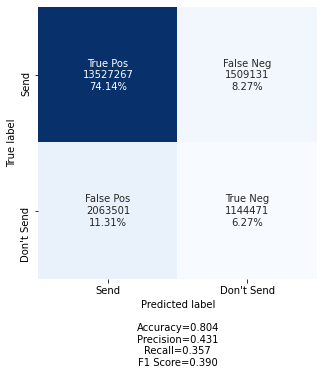

In [48]:
%%time
#Evaluate model without Thompson Sampling on full validation set
cf_matrix_no_thompson = eval_model(linear_model, thompson=False)

#Visualize the confusion matrix
labels = ["True Pos","False Neg","False Pos","True Neg"]
categories = ["Send", "Don't Send"]
make_confusion_matrix(cf_matrix_no_thompson, 
                      group_names=labels,
                      categories=categories, 
                      cbar=False,
                      figsize=(8, 8))

### With Thompson Sampling

In [ ]:
%%time
#Evaluate model without Thompson Sampling on full validation set
cf_matrix_thompson = eval_model(linear_model, thompson=False)

#Visualize the confusion matrix
labels = ["True Pos","False Neg","False Pos","True Neg"]
categories = ["Send", "Don't Send"]
make_confusion_matrix(cf_matrix_thompson, 
                      group_names=labels,
                      categories=categories, 
                      cbar=False,
                      figsize=(8, 8))